## Dataset Selection

Select a dataset identically to the way you selected for lab one or lab three (table data or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains three or more classes to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

## Grading Rubric

### Preparation (15 points total)
[5 points] (mostly the same processes as from lab four) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?

[10 points] (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

### Evaluation (30 points total)
[15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

Important: You should use your chosen evaluation criteria and chosen method for dividing train/test data throughout the report. For example, arguing that f-score is the best evaluation method, but then using accuracy in a grid search will be regarded as a conceptual error and graded accordingly. 
### Modeling (45 points total)
[20 points] Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
When instantiated, use a selectable nonlinearity function for the first layer: either sigmoid or linear 
Use a selectable cost function when instantiated: either quadratic or cross entropy

[15 points] Tune the hyper-parameters of your MLP model (at least two hyper-parameters). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. Visualize the evaluation metric(s) versus the hyper-parameters. Conclude what combination of parameters are best.

[10 points] Compare the performance of your MLP training procedure to scikit-learn. Which implementation is better in terms of generalization performance, computation time, and memory used while training?

### Exceptional Work (10 points total)
You have free reign to provide additional analyses.
One idea: Add support for more than one hidden layer or a different nonlinear activation (i.e., softmax, tanh). Please note that different activation functions might require different weight initializations to work well. 

In [14]:
import os
import sys
import random
import copy
import warnings
from random import randint
import _pickle as cPickle

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.neural_network import MLPClassifier
from scipy.misc import imread
from scipy.special import expit
import pywt # conda install -c conda-forge pywavelets
from skimage.filters import roberts, sobel, scharr, prewitt

%matplotlib inline
plt.style.use('ggplot')

In [22]:
###
# Download dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# save all files to ./imgs/
###

def get_images(): # stuck this in a function to clean up memory 
    dics = []
    for root, directory, files in os.walk('imgs'):
        for f in files:
            if 'data_batch' in f or 'test_batch' in f:
                with open(root+'/'+f, 'rb') as fo:
                    dics.append(cPickle.load(fo, encoding='latin1'))

    img_color = []
    img_labels = []
    for dic in dics:
        for i in range(len(dic['data'])):
            img_color.append(dic['data'][i]) # 1D img (1024 R, 1024 G, 1024 B)
            img_labels.append(dic['labels'][i]) # int representing the label

    img_color = np.array(img_color)
    img_labels = np.array(img_labels)

    # grab the mapping between label names and IDs
    print('Labels:')
    labels = {}
    with open('./imgs/batches.meta', 'rb') as fo:
        labels_tmp = cPickle.load(fo, encoding='latin1')
        for i in range(len(labels_tmp['label_names'])):
            labels[i] = labels_tmp['label_names'][i]
            print(i, "-->", labels_tmp['label_names'][i])
    print()

    img_label_names = np.array([labels[x] for x in img_labels])

    def toGrayscale(img):
        r, g, b = img[:1024], img[1024:2048], img[2048:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

    img_gray = np.array([toGrayscale(x) for x in img_color])
    
    return (img_gray, img_labels, img_label_names)

img_gray, img_labels, img_label_names = get_images()

print("n_samples: {}".format(len(img_gray)))
print("n_features: {}".format(len(img_gray[0])))
print("n_classes: {}".format(len(np.unique(img_labels))))
print("Original Image Size: {} x {}".format(32, 32))

Labels:
0 --> airplane
1 --> automobile
2 --> bird
3 --> cat
4 --> deer
5 --> dog
6 --> frog
7 --> horse
8 --> ship
9 --> truck

n_samples: 60000
n_features: 1024
n_classes: 10
Original Image Size: 32 x 32


In [23]:
# a helper plotting function
def plot_gallery(imgs, labels, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(imgs[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(labels[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features.reshape(1, -1))
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

def plot_explained_variance(pca):
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

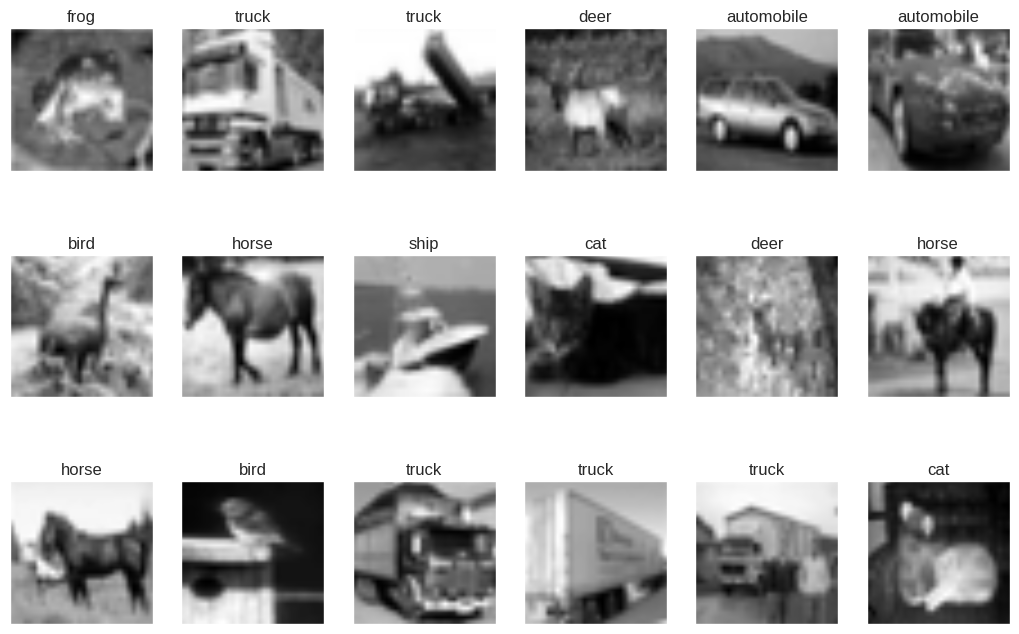

In [24]:
plot_gallery(img_gray, img_label_names, 32, 32) 

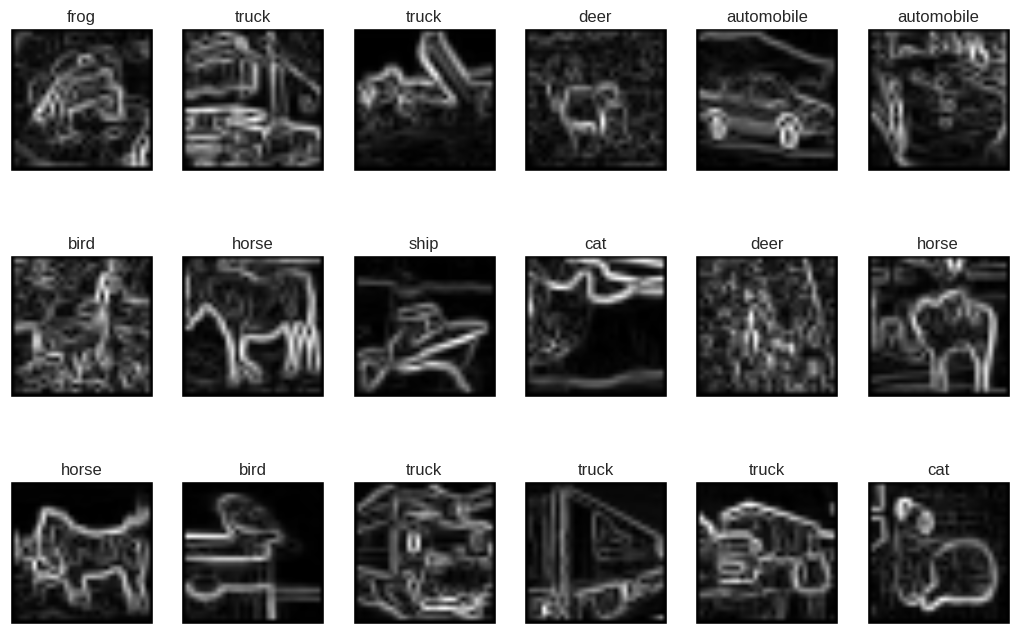

In [25]:
img_gray = [np.concatenate(roberts(x.reshape((32,32)))) for x in img_gray]
plot_gallery(img_gray, img_label_names, 32, 32) 

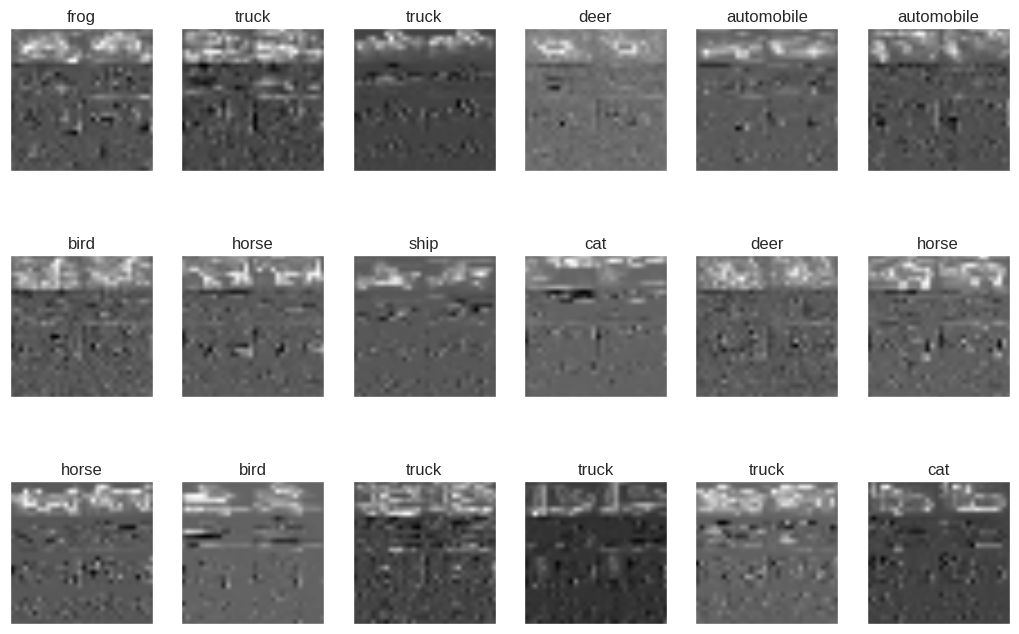

In [27]:
# https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#single-level-dwt2
for i in range(len(img_gray)):
    res = pywt.dwt2(img_gray[i].reshape((32,32)), 'haar')
    img_gray[i] = np.concatenate([np.concatenate(res[0]), np.concatenate(res[1][0]), np.concatenate(res[1][1]), np.concatenate(res[1][2])])
    # TODO: concatenate these in a way so you can actually tell what's happening in the images (4 squares)
plot_gallery(img_gray, img_label_names, 32, 32) 

In [ ]:
# OTHER IDEAS FOR IMAGE PROCESSING: https://www.quora.com/What-are-some-simple-machine-learning-algorithms-for-image-classification

## Modeling

In [28]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
class TwoLayerPerceptron(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden=30, L2_C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.L2_C = L2_C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.sqrt((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.L2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        
        Z1 = W1 @ A1.T
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        sigma2 = -2*(Y_enc-A3)*A3*(1-A3)
        sigma1 = (W2.T @ sigma2)*A2*(1-A2)
        
        grad2 = sigma2 @ A2.T
        grad1 = sigma1[1:,:] @ A1
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.L2_C
        grad2[:, 1:] += W2[:, 1:] * self.L2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self

# TODO: http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator
# check_estimator(TwoLayerPerceptron)

In [29]:
params = dict(n_hidden=50, 
              L2_C=0.01, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.0001,  # learning rate
              random_state=1)

In [30]:
x = img_gray
y = img_labels

In [33]:
#Ignoring this for now until we get it working well
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)

In [12]:
pl = Pipeline([('scaler', StandardScaler()), ('TLP', TwoLayerPerceptron(**params))])
pl.fit(x, y)
yhat = pl.predict(x)
print('Test acc:',accuracy_score(y, yhat))
print(np.bincount(yhat))

Test acc: 0.162566666667
[13111  2230  9993 22126  4021  1472     0     7  7031     9]


In [20]:
# SKLearn's implementation
pl = Pipeline([('scaler', StandardScaler()), ('MLP', MLPClassifier())])
pl.fit(x, y)
yhat = pl.predict(x)
print('Test acc:',accuracy_score(y, yhat))
print(np.bincount(yhat))

Test acc: 0.9497
[6173 6077 5946 6139 6101 5792 6026 5937 5858 5951]
